## Reading all masks from the folders and producing one single mask file

In [1]:
import cv2
import glob
import numpy as np
DATA_DIR = "./input"
split = 'names'

from __future__ import print_function, division
import os
import pandas as pd
import skimage
import random
import skimage.io
from skimage import transform
from skimage.viewer import ImageViewer
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import glob


def read_from_file(list_file, comment='#'):
    with open(list_file) as f:
        lines  = f.readlines()
    strings=[]
    for line in lines:
        s = line.split(comment, 1)[0].strip()
        if s != '':
            strings.append(s)
    return strings
        
def combining_masks():
    ids = read_from_file(DATA_DIR + '/names/' + split, comment='#')
    num_ids = len(ids)
    for i in range(num_ids):
        id = ids[i]
        image_files = glob.glob(DATA_DIR + '/' + id + '/images/*.png')
        image_file=image_files[0]
        image = cv2.imread(image_file,cv2.IMREAD_COLOR)
        H,W,C = image.shape
        one_mask = np.zeros((H,W), dtype=bool)
        mask_files =glob.glob(DATA_DIR + '/' + id + '/masks/*.png')
        for mask_file in mask_files:
            mask = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
            one_mask = one_mask |(mask>128)
        one_mask = (one_mask*255).astype(np.uint8)
        cv2.imwrite(DATA_DIR + '/' + id + '/mask.png', one_mask)


/anaconda/envs/py35/lib/python3.5/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [ ]:
combining_masks()

### Splitting dataset ids on training and validation

In [2]:
from sklearn.model_selection import train_test_split
ids = read_from_file(DATA_DIR + '/names/' + split, comment='#')
num_ids = len(ids)
ids_train, ids_test = train_test_split(ids, test_size=0.20, random_state=42)

## All random data augmentations in one function

In [3]:
def data_aug(image,label,angel=5,resize_rate=0.3, output_size=256):

    flip = random.randint(0, 1)
    size = image.shape[0]
    sh = random.random()/2-0.25
    rotate_angel = random.random()/180*np.pi*angel
    sigma = random.uniform(0,0.6)
    scaling = random.uniform(0.1,1)
    
    # Rescale
    transform.rescale(image, scaling, mode='reflect')
    transform.rescale(label, scaling, mode='reflect')   
        
    # Create affine transform
    afine_tf = transform.AffineTransform(shear=sh,rotation=rotate_angel)
    
    # Apply transform to image data|
    image = transform.warp(image, inverse_map=afine_tf,mode='edge')
    label = transform.warp(label, inverse_map=afine_tf,mode='edge')
    
    # Ramdomly flip frame
    if flip:
        image = image[:,::-1,:]
        label = label[:,::-1]
        
    #Shuffle the RGB channels to get color invariance
    p = [0,1,2]
    random.shuffle(p)
    image[:,:,:] = image[:,:,p]    
    #Change exposure/intensity randomly:
    imageAlp = image[:,:,2]  
    imageRest = image[:,:,0:3]
    if random.randint(0,1)==0:
        #use clahe
        image = exposure.equalize_adapthist(image)    
    if random.randint(0,1)==0:
        image = exposure.rescale_intensity(image,(0,random.uniform(0.5,1)))        
    
    #Rotate the image
    rotate = random.randint(0,3)
    image = transform.rotate(image, rotate*np.pi/2, mode='reflect')
    label = transform.rotate(label, rotate*np.pi/2, mode='reflect')

    #Corrupt data a little
    if sigma > 0:
        image = np.minimum(np.maximum(0.0,image + np.random.normal(0, sigma, image.shape)/255.0),255.0)
    
    
    # Randomly cropping image frame
    rsize = random.randint(np.floor(resize_rate*size),size)
    w_s = random.randint(0,size - rsize)
    h_s = random.randint(0,size - rsize)
    image = image[w_s:w_s+size,h_s:h_s+size,:]
    label = label[w_s:w_s+size,h_s:h_s+size]
    
    
    #Now we resize the image
    image = transform.resize(image, (output_size, output_size))
    label = transform.resize(label, (output_size, output_size))
    image = image.transpose(2, 0, 1)
    #label  = cv2.threshold(label, 128, 255, cv2.THRESH_BINARY)[1]
    label[label > 0.] = 1
    return image.astype(float), label.astype(float)


## Creating Dataset to use it in DataLoader

In [4]:
from torch.utils.data.dataset import Dataset

class ImageMaskDataset(Dataset):

    def __init__(self, ids, mode='train', transform= None):
        super(ImageMaskDataset, self).__init__()
        self.split = split
        self.mode = mode
        self.transform = transform
        self.ids = ids

    def __getitem__(self, index):
        id   = self.ids[index]
        name = id.split('/')[-1]
        image_file = DATA_DIR + '/' + id + '/images/' + name +'.png'
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)

        if self.mode in ['train']:
            mask_file =  DATA_DIR + '/' + id + '/mask.png'
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            return self.transform(image,mask)

        if self.mode in ['test']:
            return self.transform(image)

    def __len__(self):
        return len(self.ids)

#### Function for image visualisation

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *
def image_show(name, image, resize=1):
    H,W = image.shape[0:2]
    cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    cv2.imshow(name, image.astype(np.uint8))
    cv2.resizeWindow(name, round(resize*W), round(resize*H))

#### Simple data augmentation for testing

In [6]:
WIDTH = 256
HIGHT =256
def simple_augment(image,mask, output_size=256):
    #Now we resize the image
    image = transform.resize(image, (output_size, output_size))
    label = transform.resize(mask, (output_size, output_size))
    image = image.transpose(2, 0, 1)
    #label  = cv2.threshold(label, 128, 255, cv2.THRESH_BINARY)[1]
    label[label > 0.] = 1
    return image.astype(float), label.astype(float)

dataset = ImageMaskDataset(
        ids_train, mode='train', transform = data_aug
    )
sampler = RandomSampler(dataset)

In [7]:
dataset[1][0]

/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[[0.01444019, 0.01749251, 0.01658754, ..., 0.01513303,
         0.01593038, 0.01409136],
        [0.01446812, 0.0197074 , 0.0201048 , ..., 0.02079955,
         0.01966557, 0.01404035],
        [0.01235516, 0.0181293 , 0.01992972, ..., 0.02247729,
         0.02036097, 0.01356917],
        ...,
        [0.01983371, 0.02234898, 0.02220182, ..., 0.02269182,
         0.02285425, 0.02185217],
        [0.01812652, 0.02163522, 0.02182194, ..., 0.0209097 ,
         0.02199089, 0.02195954],
        [0.01449072, 0.01840714, 0.01833601, ..., 0.015152  ,
         0.01774005, 0.01901641]],

       [[0.01206229, 0.01434147, 0.01582839, ..., 0.01762811,
         0.0162639 , 0.01237008],
        [0.01242412, 0.01595278, 0.01809293, ..., 0.02013392,
         0.01819795, 0.01399861],
        [0.01140307, 0.01487849, 0.01738472, ..., 0.01999658,
         0.01858469, 0.01466238],
        ...,
        [0.01966713, 0.02147287, 0.02274584, ..., 0.0222117 ,
         0.02363669, 0.02081436],
        [0.0

## `UNet` class is based on https://arxiv.org/pdf/1801.05746.pdf

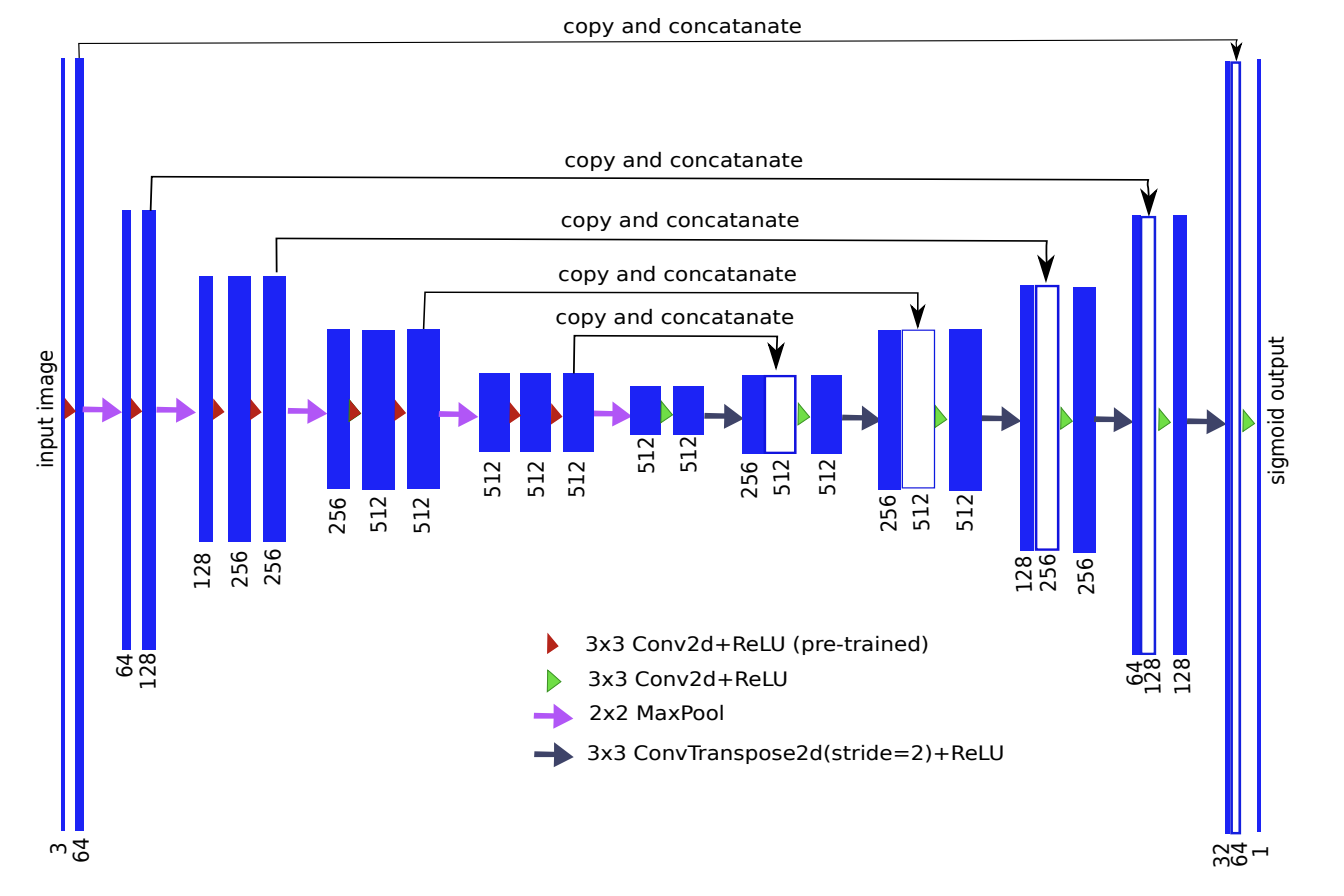

In [8]:
import torch.nn as nn
def UpDownConv(in_channels, mid_channels, out_channels):
    return nn.Sequential(
            *ConvRelu(in_channels, mid_channels, kernel_size=3, stride=1, padding=1 ),
            *ConvRelu(mid_channels, out_channels, kernel_size=3, stride=1, padding=1 ),
    )
def ConvRelu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
class UNet(nn.Module):
    
    def __init__(self, in_shape, num_classes):
        super(UNet, self).__init__()
        in_channels, height, width = in_shape

        self.down1 = nn.Sequential(
            *ConvRelu(in_channels, 16, kernel_size=3, stride=1, padding=1 ),
            *ConvRelu(16, 32, kernel_size=3, stride=2, padding=1 ),
        )
        #64
        self.down2 = UpDownConv(32, 64, 128)
        #32
        self.down3 = UpDownConv(128, 256, 512)
        #16
        self.down4 = UpDownConv(512, 512, 512)
        #8
        self.same = nn.Sequential(
            *ConvRelu(512,512, kernel_size=1, stride=1, padding=0 ),
        )
        #16
        self.up4 = UpDownConv(1024, 512, 512)
        #16
        self.up3 = UpDownConv(1024, 512, 128)
        #32
        self.up2 = UpDownConv(256, 128, 32)
        #64
        self.up1 = UpDownConv(64, 64, 32)
        #128

        self.up0 = nn.Sequential(
            *ConvRelu(32, 32, kernel_size=3, stride=1, padding=1 ),
        )
        #256

        self.classify = nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0 )

    def forward(self, x):

        down1 = self.down1(x)
        out   = F.max_pool2d(down1, kernel_size=2, stride=2) #64
        down2 = self.down2(out)
        out   = F.max_pool2d(down2, kernel_size=2, stride=2) #32
        down3 = self.down3(out)
        out   = F.max_pool2d(down3, kernel_size=2, stride=2) #16
        down4 = self.down4(out)
        out   = F.max_pool2d(down4, kernel_size=2, stride=2) # 8
        out   = self.same(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #16
        out   = torch.cat([down4, out],1)
        out   = self.up4(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #32
        out   = torch.cat([down3, out],1)
        out   = self.up3(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #64
        out   = torch.cat([down2, out],1)
        out   = self.up2(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #128
        out   = torch.cat([down1, out],1)
        out   = self.up1(out)
        out   = F.upsample(out, scale_factor=2, mode='bilinear') #256
        out   = self.up0(out)
        out   = self.classify(out)
        return out
    

In [10]:
num_classes = 1
batch_size  = 8
C = 3
from torch.autograd import Variable
import torch.nn.functional as F

inputs = torch.randn(batch_size,C,HIGHT,WIDTH)
labels = torch.LongTensor(batch_size,HIGHT,WIDTH).random_(1).type(torch.FloatTensor)

net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train().cuda()
x = Variable(inputs).cuda()
y = Variable(labels).cuda()
logits = net.forward(x)

probs = F.sigmoid(logits)
probs_flat = probs.view (-1)
targets_flat = y.view(-1)
loss = nn.BCELoss().cuda()
output = loss(probs_flat, targets_flat)
output.backward()

print(type(net))
print(net)

<class '__main__.UNet'>
UNet(
  (down1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(256, 512

In [11]:
output

Variable containing:
 0.7573
[torch.cuda.FloatTensor of size 1 (GPU 0)]

### Soft Dice Loss implementation:

In [12]:
class DiceLoss(nn.Module):
    def __init__(self): 
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1.
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()

        return 1 - ((2. * intersection + smooth) /
                    (iflat.sum() + tflat.sum() + smooth))

## Validation function

In [13]:
net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).cuda()
net.load_state_dict(torch.load(DATA_DIR +'/checkpoint/model.pth'))
    
validation_dataset = ImageMaskDataset(
                            ids_test, mode='train',
                            transform = simple_augment)
    
    
validation_loader  = DataLoader(
                        validation_dataset,
                        sampler = RandomSampler(validation_dataset),
                        batch_size  = 1,
                        drop_last   = True,
                        num_workers = 8)

In [14]:
def validation_loss(net, loader, loss_type):
    validation_loader = loader
    net.eval()
    totall_val_loss = 0
    val_batch_num = 0
    for val_index, val_data in enumerate(validation_loader):
        val_image, val_mask = val_data
        if cuda:
            val_tensors = Variable(val_image).cuda()
            val_masks   = Variable(val_mask).cuda()
        else:
            val_tensors = Variable(val_image)
            val_masks   = Variable(val_mask)
        val_logits  = net(val_tensors.float())
        if loss_type == "BCE":
            val_loss = nn.BCELoss()
            val_probs   = F.sigmoid(val_logits)
            val_probs_flat = val_probs.view(-1)
            val_masks_flat = val_masks.view(-1)
        elif loss_type == "DICE":
            val_loss = DiceLoss()
            val_probs   = F.sigmoid(val_logits)
            val_probs_flat = val_probs.view(-1)
            val_masks_flat = val_masks.view(-1)
            
        elif loss_type == "NLLL":
            val_loss = nn.CrossEntropyLoss()
            val_probs = F.log_softmax(val_logits)
            val_probs_flat = val_probs
            val_masks_flat = val_masks
            
        if cuda:
            val_loss = val_loss.cuda()
        output = val_loss(val_probs_flat, val_masks_flat.float())
        totall_val_loss += output.data[0]
        val_batch_num += 1
    net.train()
    print('\r validation loss:  %f' % (totall_val_loss/val_batch_num))
    return totall_val_loss/val_batch_num

In [15]:
def jaccard(x,y):
    x = np.asarray(x, np.bool) 
    y = np.asarray(y, np.bool) 
    return 1- np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum())

def val_jac_loss(net, loader, im_print):
    validation_loader = loader
    net.eval()
    totall_val_loss = 0
    val_batch_num = 0
    for val_index, val_data in enumerate(validation_loader):
        val_image, val_mask = val_data
        if cuda:
            val_tensors = Variable(val_image).cuda()
            val_masks   = Variable(val_mask).cuda()
        else:
            val_tensors = Variable(val_image)
            val_masks   = Variable(val_mask)
        val_logits  = net(val_tensors.float())
        val_probs   = F.sigmoid(val_logits)
        images = val_tensors.data.cpu().numpy()
        masks  = val_masks.data.cpu().numpy()
        probs  = val_probs.data.cpu().numpy()
        probs[probs > 0.5] = 1.0
        probs[probs <= 0.5] = 0.0
        x = np.copy(probs)
        y = np.copy(masks)
        x = np.squeeze(x, axis=1)
        totall_val_loss += jaccard(x,y)
        if im_print:
            for i in range(len(images)):
                image = images[i].transpose((1,2,0))*255
                mask  = (masks[i]*255).astype(np.uint8)
                prob  = np.squeeze((probs[i]*255).astype(np.uint8), axis=0)
                image = image.astype(np.uint8)
                plt.subplot(131)
                plt.imshow(image)
                plt.axis('off')
                plt.subplot(132)
                plt.imshow(mask)
                plt.axis('off')
                plt.subplot(133)
                plt.imshow(prob)
                plt.axis('off')
                plt.show()
        val_batch_num += 1
    net.train()
    print('\r Jaccard validation error:  %f' % (totall_val_loss/val_batch_num))
    return totall_val_loss/val_batch_num

### Training prodecure 

In [18]:
import torch.optim as optim
LR = 0.0002
batch_size = 32
net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train()
epochs = 100
cuda = True
ADAM = True


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
def train(loss_type, augmentation, jaccard):
    if ADAM:
        optimizer = \
                    optim.Adam(net.parameters(),
                               lr= LR, betas=(0.5, 0.999))
    else:
        optimizer = \
                    optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                              lr=0.01/iter_accum, momentum=0.9, weight_decay=0.0001)
            
        
    train_dataset = ImageMaskDataset(
                                ids_train, mode='train',
                                transform = augmentation)
    validation_dataset = ImageMaskDataset(
                                ids_test, mode='train',
                                transform = simple_augment)
    
    train_loader  = DataLoader(
                        train_dataset,
                        sampler = RandomSampler(train_dataset),
                        batch_size  = batch_size,
                        drop_last   = True,
                        num_workers = 8)
    
    validation_loader  = DataLoader(
                        validation_dataset,
                        sampler = RandomSampler(validation_dataset),
                        batch_size  = 1,
                        drop_last   = True,
                        num_workers = 8)
    
    i = 0
    if cuda:
        net.cuda()
    val_losses = []
    train_losses = []
    while  i < epochs:  
        sum_train_loss = 0.0
        sum_train_acc  = 0.0
        sum = 0
        net.train()
        optimizer.zero_grad()
        j = 0
        sum_per_batch = 0
        for index, data  in enumerate(train_loader):
            j = j+1
            image,mask = data
            if cuda:
                tensors = Variable(image).cuda()
                masks   = Variable(mask).cuda()
            else:
                tensors = Variable(image)
                masks   = Variable(mask)
            logits  = net(tensors.float())
            if loss_type == "BCE":
                probs   = F.sigmoid(logits)
                loss = nn.BCELoss()
                probs_flat = probs.view(-1)
                masks_flat = masks.view(-1)
            elif loss_type == "DICE":
                probs   = F.sigmoid(logits)
                loss = DiceLoss()
                probs_flat = probs.view(-1)
                masks_flat = masks.view(-1)
            elif loss_type == "NLLL":
                probs = F.log_softmax(logits)
                loss = nn.CrossEntropyLoss()
                probs_flat = probs
                masks_flat = masks
            if cuda:
                loss = loss.cuda()
                
            output = loss(probs_flat, masks_flat.float())
            output.backward()
            optimizer.step()
            optimizer.zero_grad()
            adjust_learning_rate(optimizer, i)
            batch_loss = output.data[0]
            sum_per_batch += batch_loss
                
            for param_group in optimizer.param_groups:
                current_lr = param_group['lr']
            print('\r epoch: %d| LR: %f|batch_loss:  %f  sum_train_loss: %f'% \
                      (i, current_lr, batch_loss, sum_per_batch/j), end='',flush=True)
        i = i +1
        if(i%10 == 0):
            print('\r epoch: %d| LR: %f|batch_loss:  %f  sum_train_loss: %f\n'% \
                      (i, current_lr, batch_loss, sum_per_batch/j), end='',flush=True)
            if jaccard:
                val_losses.append(val_jac_loss(net, validation_loader, False))
            else:
                val_losses.append(validation_loss(net, validation_loader, loss_type))
            train_losses.append(sum_per_batch/j)
            images = tensors.data.cpu().numpy()
            masks  = masks.data.cpu().numpy()
            probs  = probs.data.cpu().numpy()
            image = images[0].transpose((1,2,0))*255
            mask  = (masks[0]*255).astype(np.uint8)
            prob  = np.squeeze((probs[0]*255).astype(np.uint8), axis=0)
            image = image.astype(np.uint8)
            plt.subplot(131)
            plt.imshow(image)
            plt.subplot(132)
            plt.imshow(mask)
            plt.subplot(133)
            plt.imshow(prob)
            plt.show()
    return train_losses, val_losses

 epoch: 10| LR: 0.000200|batch_loss:  0.377682  sum_train_loss: 0.395631
 validation loss:  0.385927


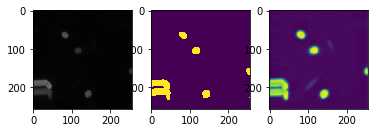

 epoch: 20| LR: 0.000200|batch_loss:  0.296466  sum_train_loss: 0.312250
 validation loss:  0.328132


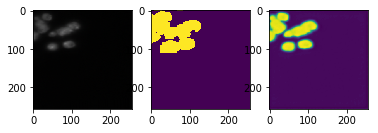

 epoch: 30| LR: 0.000200|batch_loss:  0.247044  sum_train_loss: 0.254738
 validation loss:  0.235394


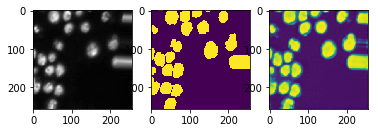

 epoch: 40| LR: 0.000020|batch_loss:  0.299443  sum_train_loss: 0.239897
 validation loss:  0.246915


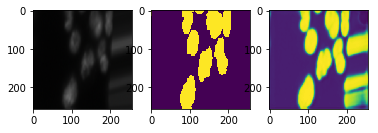

 epoch: 50| LR: 0.000020|batch_loss:  0.238577  sum_train_loss: 0.235914
 validation loss:  0.241556


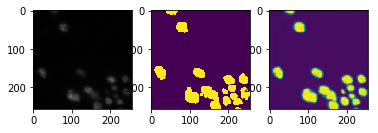

 epoch: 60| LR: 0.000020|batch_loss:  0.218292  sum_train_loss: 0.226995
 validation loss:  0.234380


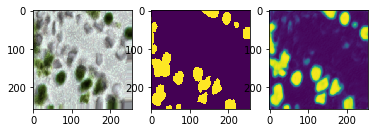

 epoch: 70| LR: 0.000002|batch_loss:  0.220308  sum_train_loss: 0.227399
 validation loss:  0.235564


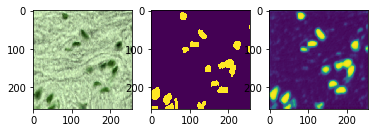

 epoch: 80| LR: 0.000002|batch_loss:  0.231606  sum_train_loss: 0.225205
 validation loss:  0.228776


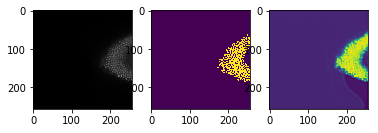

 epoch: 90| LR: 0.000002|batch_loss:  0.227427  sum_train_loss: 0.226167
 validation loss:  0.237273


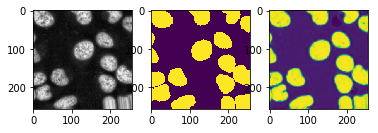

 epoch: 100| LR: 0.000000|batch_loss:  0.222470  sum_train_loss: 0.225736
 validation loss:  0.232681


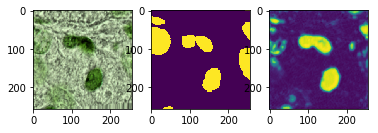

In [15]:
import warnings
warnings.filterwarnings('ignore')
train_BCE, val_BCE = train("BCE", data_aug)

In [20]:
import torch 
torch.save(net.state_dict(), DATA_DIR +'/checkpoint/model_BCE.pth')

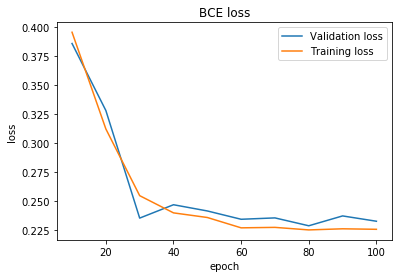

In [42]:
from matplotlib import pyplot as plt
plt.plot(list(range(10,110, 10)),val_BCE, label='Validation loss')
plt.plot(list(range(10,110, 10)),train_BCE, label='Training loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('BCE loss')
plt.legend()

 epoch: 10| LR: 0.000200|batch_loss:  0.526841  sum_train_loss: 0.500355
 validation loss:  0.573406


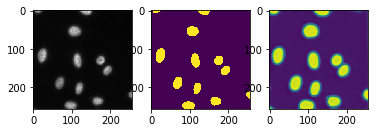

 epoch: 20| LR: 0.000200|batch_loss:  0.374235  sum_train_loss: 0.420624
 validation loss:  0.507948


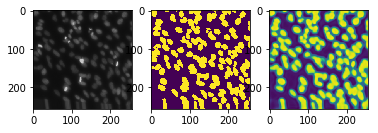

 epoch: 30| LR: 0.000200|batch_loss:  0.293245  sum_train_loss: 0.339608
 validation loss:  0.393417


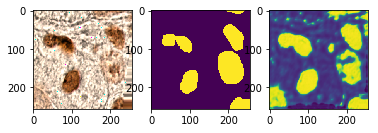

 epoch: 40| LR: 0.000020|batch_loss:  0.296360  sum_train_loss: 0.322770
 validation loss:  0.396108


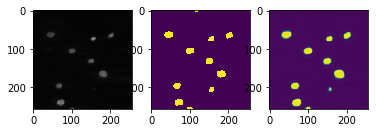

 epoch: 50| LR: 0.000020|batch_loss:  0.291611  sum_train_loss: 0.307889
 validation loss:  0.386512


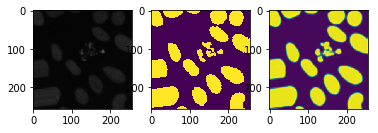

 epoch: 60| LR: 0.000020|batch_loss:  0.400839  sum_train_loss: 0.307871
 validation loss:  0.386679


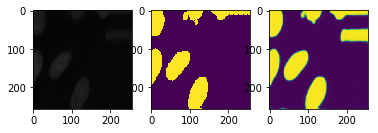

 epoch: 70| LR: 0.000002|batch_loss:  0.311235  sum_train_loss: 0.304173
 validation loss:  0.371208


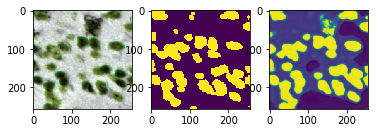

 epoch: 80| LR: 0.000002|batch_loss:  0.276284  sum_train_loss: 0.299226
 validation loss:  0.380183


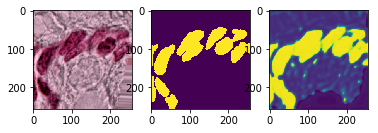

 epoch: 90| LR: 0.000002|batch_loss:  0.262043  sum_train_loss: 0.301888
 validation loss:  0.382477


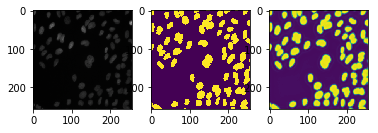

 epoch: 100| LR: 0.000000|batch_loss:  0.320435  sum_train_loss: 0.307030
 validation loss:  0.367746


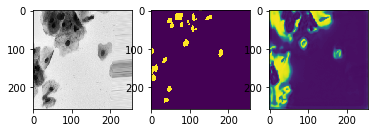

In [16]:
import warnings
warnings.filterwarnings('ignore')
train_DICE, val_DICE = train("DICE", data_aug)

In [17]:
import torch 
torch.save(net.state_dict(), DATA_DIR +'/checkpoint/model_DICE.pth')

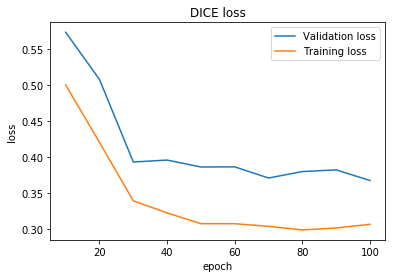

In [18]:
from matplotlib import pyplot as plt
plt.plot(list(range(10,110, 10)),val_DICE, label='Validation loss')
plt.plot(list(range(10,110, 10)),train_DICE, label='Training loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('DICE loss')
plt.legend()

 epoch: 10| LR: 0.000200|batch_loss:  0.432191  sum_train_loss: 0.429673
 validation loss:  0.430513


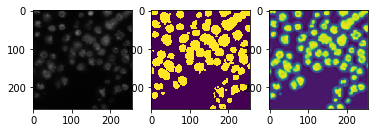

 epoch: 20| LR: 0.000200|batch_loss:  0.346039  sum_train_loss: 0.347014
 validation loss:  0.357353


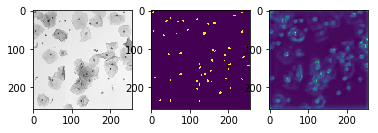

 epoch: 30| LR: 0.000200|batch_loss:  0.277051  sum_train_loss: 0.276427
 validation loss:  0.269172


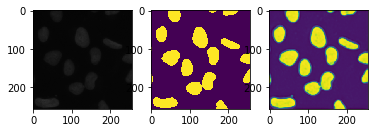

 epoch: 40| LR: 0.000020|batch_loss:  0.287423  sum_train_loss: 0.265438
 validation loss:  0.259897


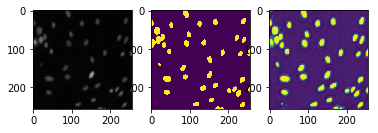

 epoch: 50| LR: 0.000020|batch_loss:  0.258830  sum_train_loss: 0.259774
 validation loss:  0.254840


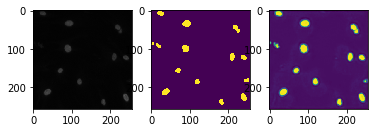

 epoch: 60| LR: 0.000020|batch_loss:  0.251221  sum_train_loss: 0.253254
 validation loss:  0.248828


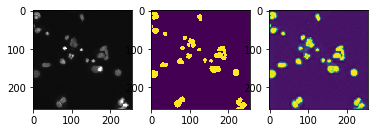

 epoch: 70| LR: 0.000002|batch_loss:  0.262742  sum_train_loss: 0.250931
 validation loss:  0.249287


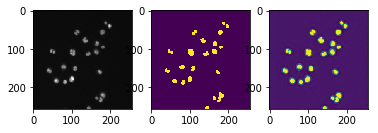

 epoch: 80| LR: 0.000002|batch_loss:  0.248330  sum_train_loss: 0.250380
 validation loss:  0.245826


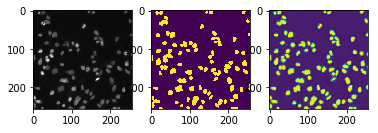

 epoch: 90| LR: 0.000002|batch_loss:  0.245721  sum_train_loss: 0.249496
 validation loss:  0.244049


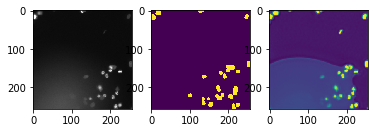

 epoch: 100| LR: 0.000000|batch_loss:  0.243547  sum_train_loss: 0.249240
 validation loss:  0.245176


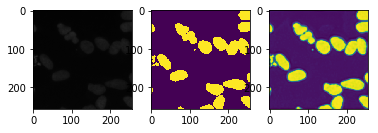

In [16]:
import warnings
warnings.filterwarnings('ignore')
train_BCE_simple, val_BCE_simple = train("BCE", simple_augment)

In [17]:
import torch 
torch.save(net.state_dict(), DATA_DIR +'/checkpoint/model_BCE_with_no_aug.pth')

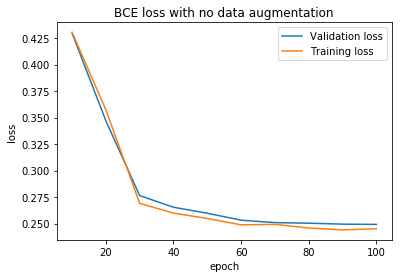

In [18]:
from matplotlib import pyplot as plt
plt.plot(list(range(10,110, 10)),train_BCE_simple, label='Validation loss')
plt.plot(list(range(10,110, 10)),val_BCE_simple, label='Training loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('BCE loss with no data augmentation')
plt.legend()

 epoch: 10| LR: 0.000200|batch_loss:  0.558379  sum_train_loss: 0.586953
 validation loss:  0.620617


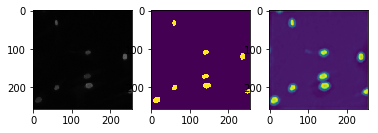

 epoch: 20| LR: 0.000200|batch_loss:  0.523247  sum_train_loss: 0.515258
 validation loss:  0.546648


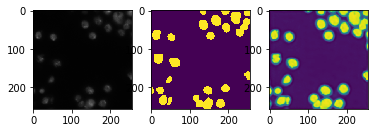

 epoch: 30| LR: 0.000200|batch_loss:  0.405362  sum_train_loss: 0.416299
 validation loss:  0.433134


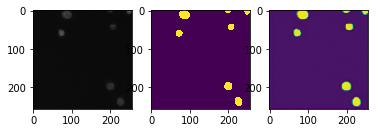

 epoch: 40| LR: 0.000020|batch_loss:  0.454282  sum_train_loss: 0.401604
 validation loss:  0.433209


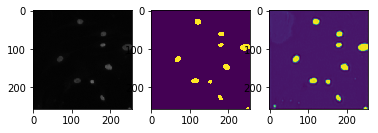

 epoch: 50| LR: 0.000020|batch_loss:  0.424937  sum_train_loss: 0.387575
 validation loss:  0.425414


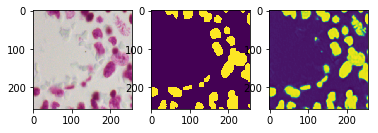

 epoch: 60| LR: 0.000020|batch_loss:  0.383272  sum_train_loss: 0.375089
 validation loss:  0.403415


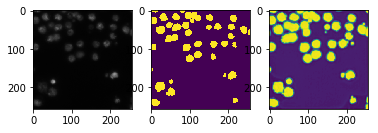

 epoch: 70| LR: 0.000002|batch_loss:  0.322129  sum_train_loss: 0.379315
 validation loss:  0.406401


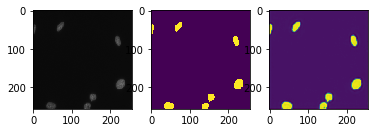

 epoch: 80| LR: 0.000002|batch_loss:  0.415445  sum_train_loss: 0.377200
 validation loss:  0.412583


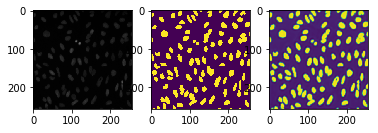

 epoch: 90| LR: 0.000002|batch_loss:  0.406203  sum_train_loss: 0.373484
 validation loss:  0.410169


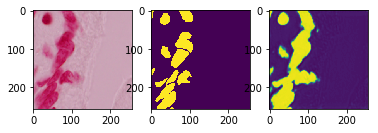

 epoch: 100| LR: 0.000000|batch_loss:  0.396527  sum_train_loss: 0.374156
 validation loss:  0.408586


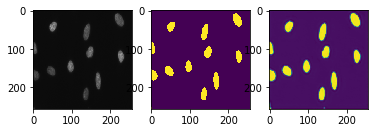

In [15]:
import warnings
warnings.filterwarnings('ignore')
train_DICE_simple, val_DICE_simple = train("DICE", simple_augment)

In [16]:
import torch 
torch.save(net.state_dict(), DATA_DIR +'/checkpoint/model_DICE_with_no_aug.pth')

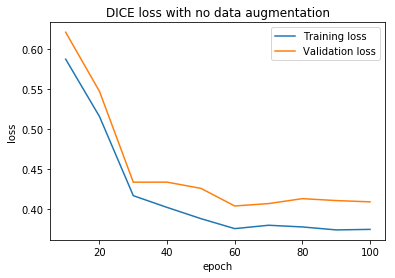

In [18]:
from matplotlib import pyplot as plt
plt.plot(list(range(10,110, 10)),train_DICE_simple, label='Training loss')
plt.plot(list(range(10,110, 10)),val_DICE_simple, label='Validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('DICE loss with no data augmentation')
plt.legend()

## Validation error with Jaccard

In [22]:
net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train()
net.load_state_dict(torch.load(DATA_DIR +'/checkpoint/model_BCE.pth'))
net.cuda()

UNet(
  (down1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(256, 512, kernel_size=(3, 3), st

In [71]:
validation_dataset = ImageMaskDataset(
                            ids_test, mode='train',
                            transform = simple_augment)
    
    
validation_loader  = DataLoader(
                        validation_dataset,
                        sampler = SequentialSampler(validation_dataset),
                        batch_size  = 1,
                        drop_last   = True,
                        num_workers = 8)

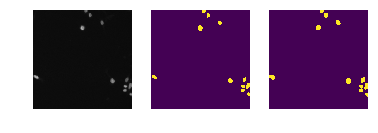

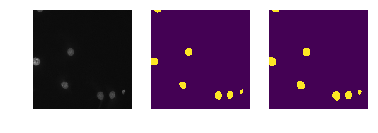

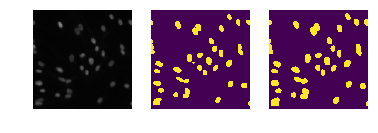

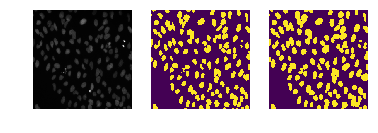

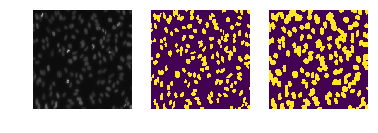

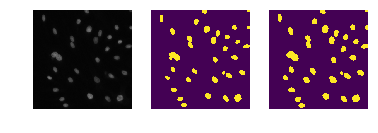

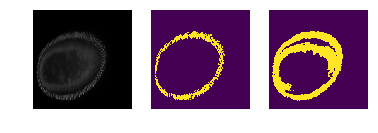

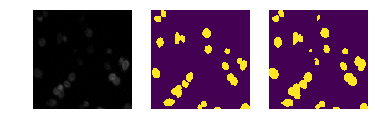

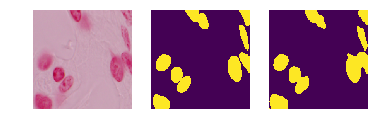

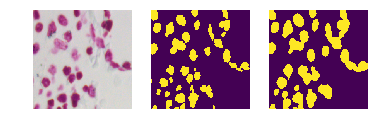

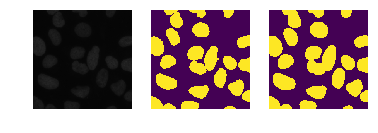

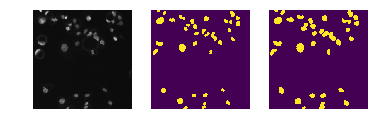

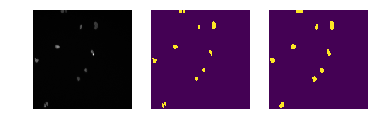

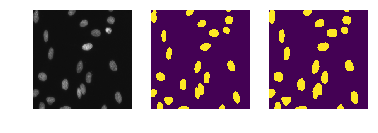

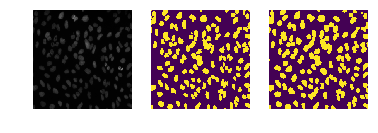

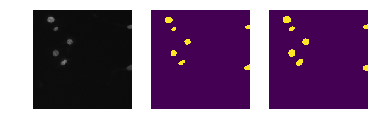

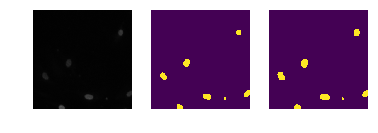

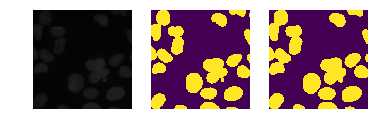

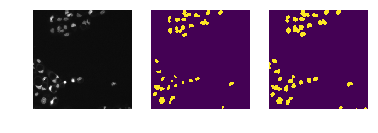

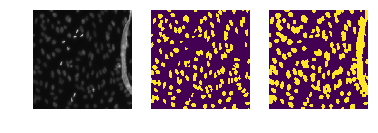

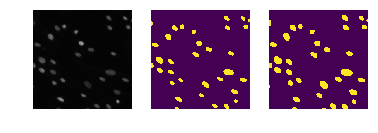

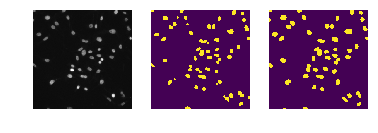

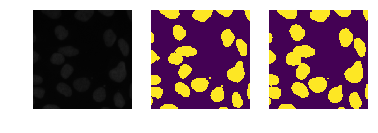

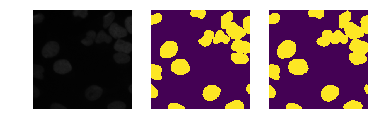

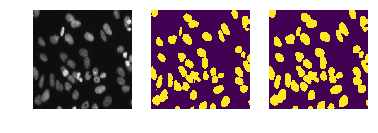

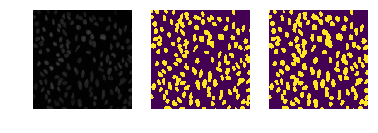

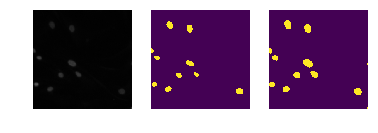

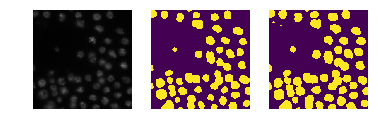

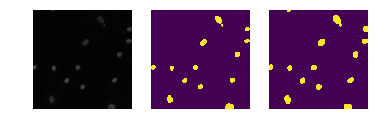

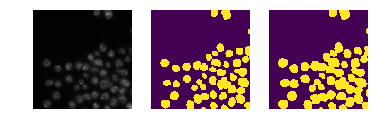

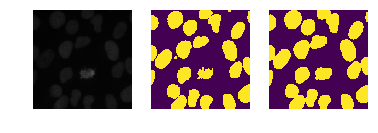

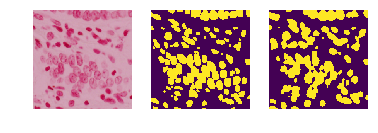

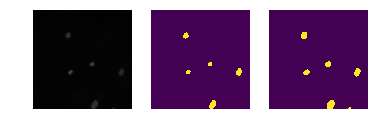

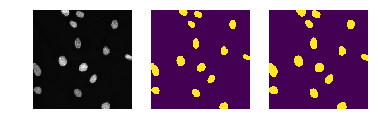

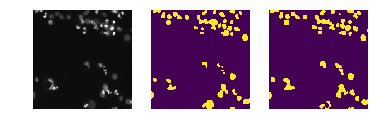

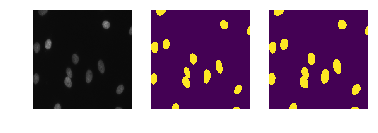

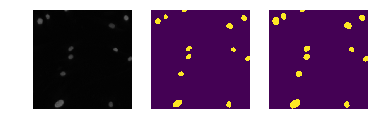

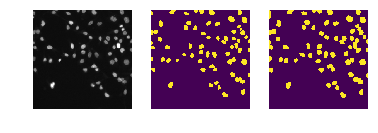

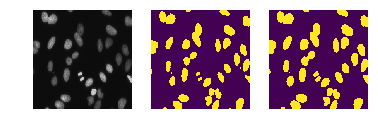

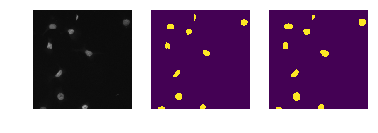

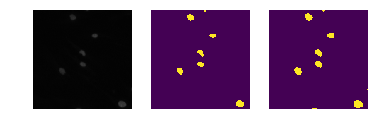

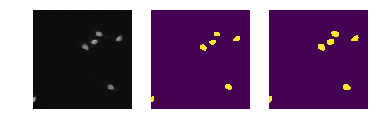

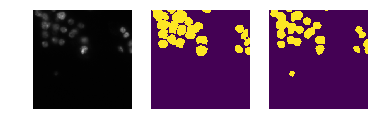

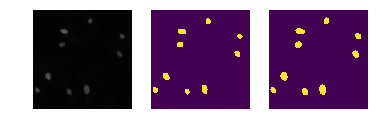

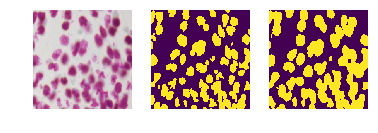

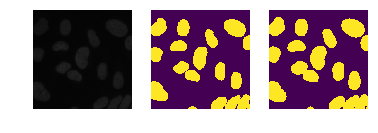

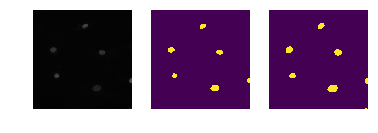

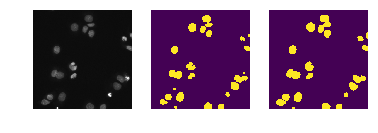

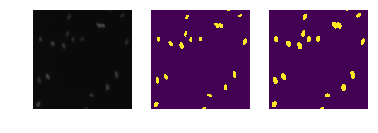

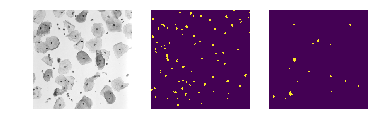

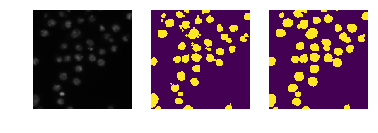

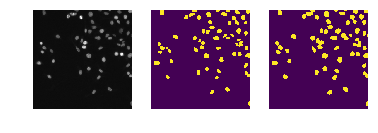

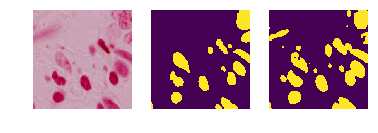

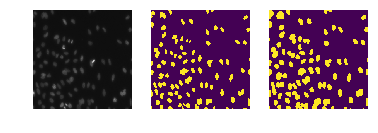

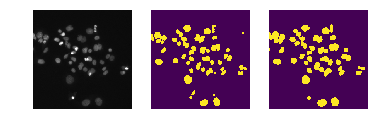

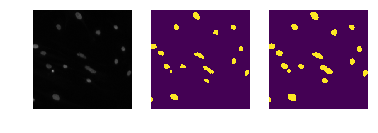

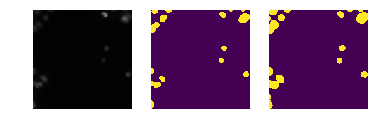

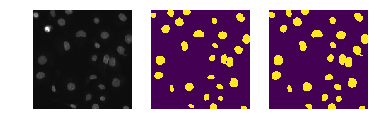

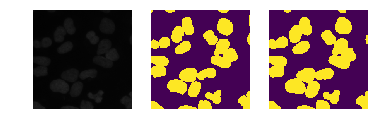

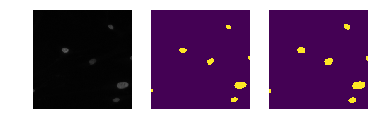

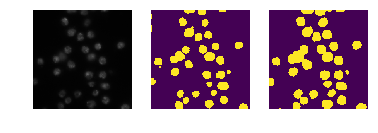

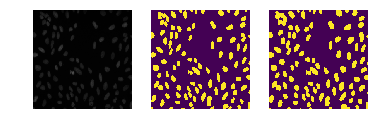

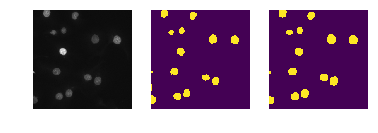

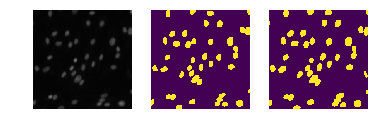

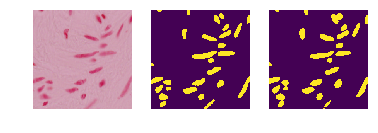

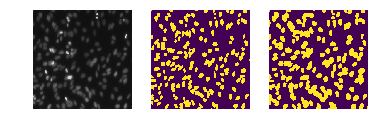

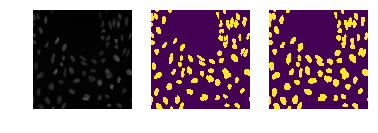

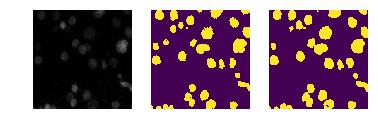

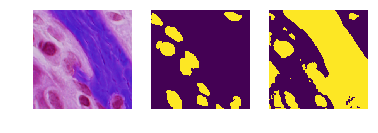

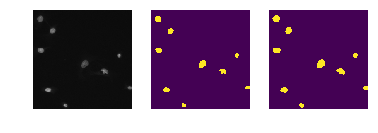

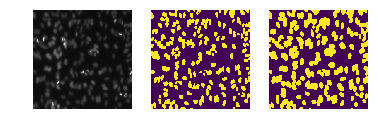

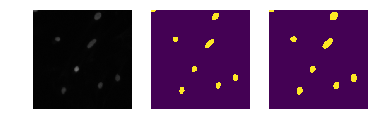

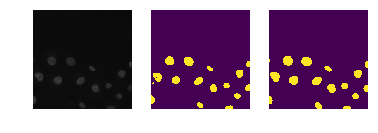

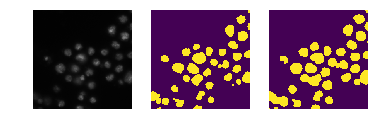

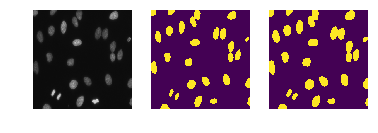

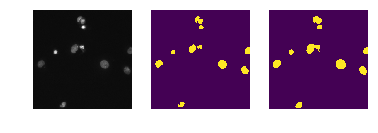

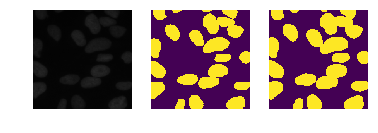

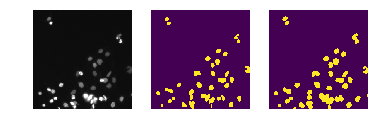

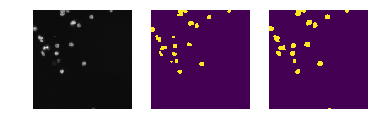

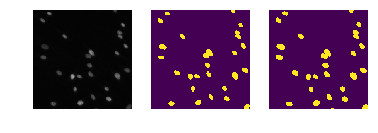

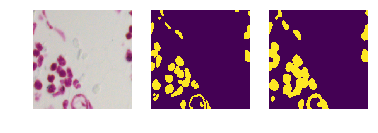

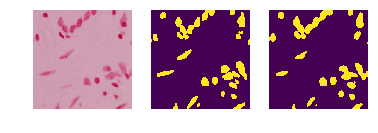

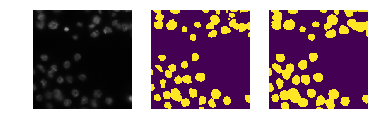

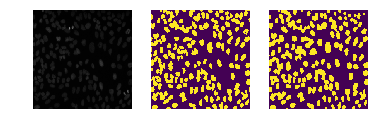

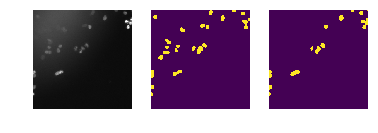

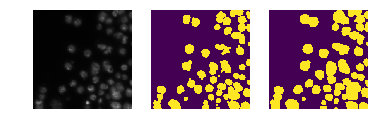

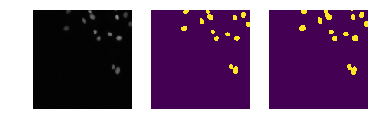

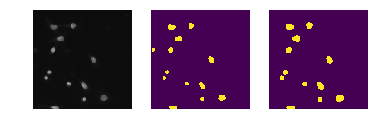

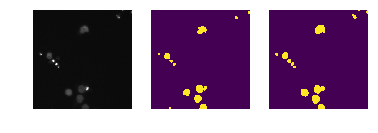

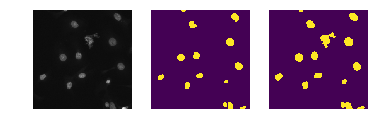

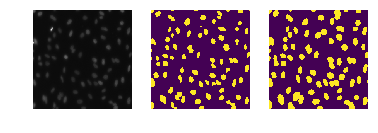

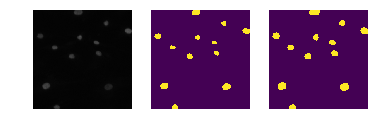

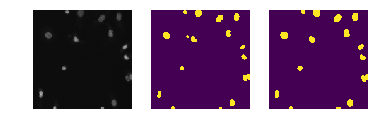

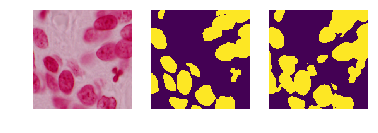

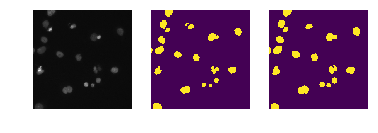

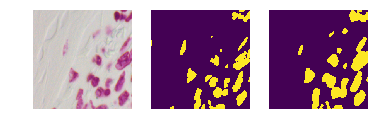

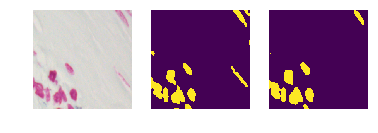

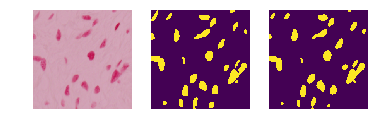

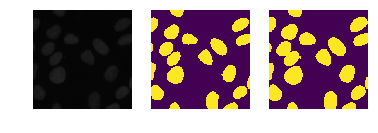

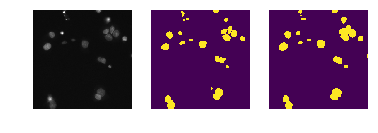

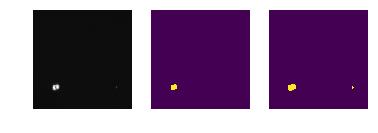

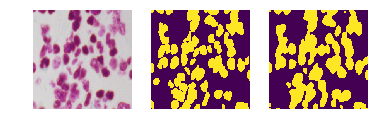

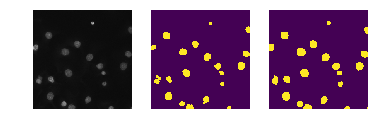

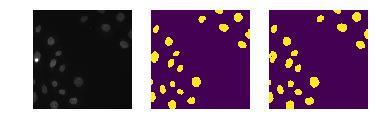

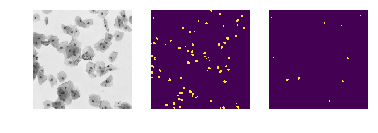

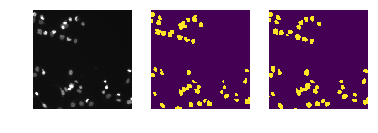

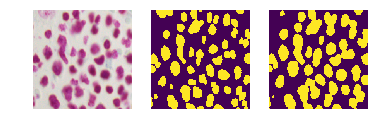

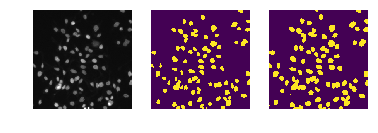

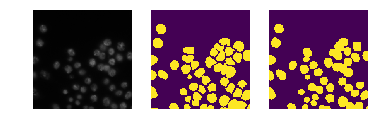

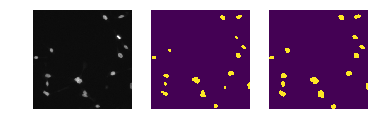

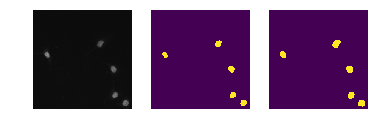

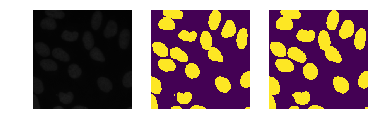

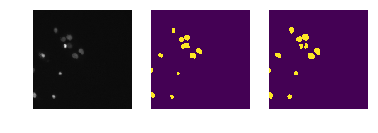

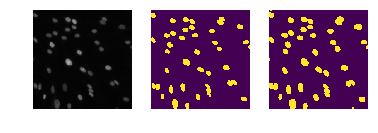

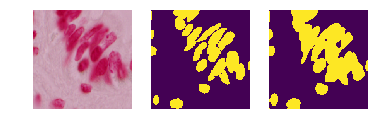

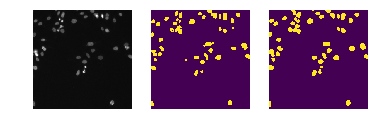

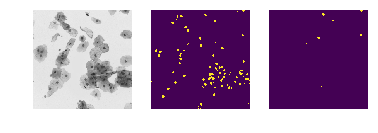

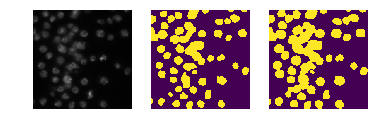

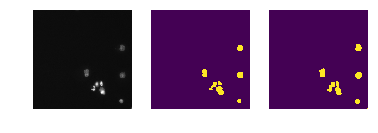

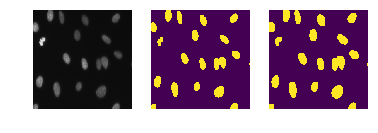

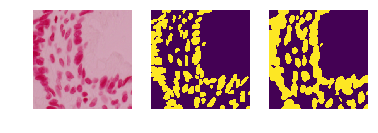

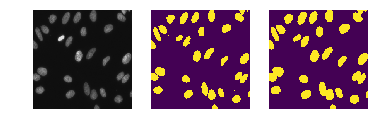

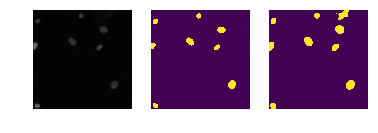

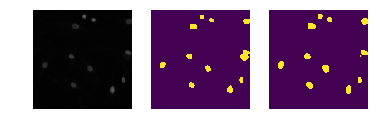

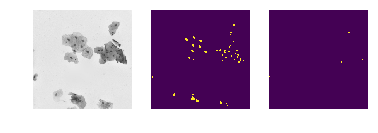

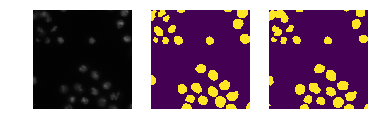

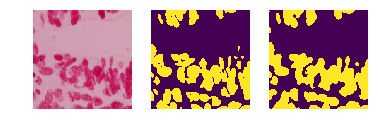

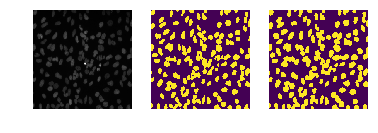

 validation loss:  0.240862


0.24086214009146623

In [24]:
import warnings
warnings.filterwarnings('ignore')
val_jac_loss(net, validation_loader, True)

In [25]:
net = UNet(in_shape=(C,HIGHT,WIDTH), num_classes=1).train()
net.load_state_dict(torch.load(DATA_DIR +'/checkpoint/model_DICE.pth'))
net.cuda()

UNet(
  (down1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(256, 512, kernel_size=(3, 3), st

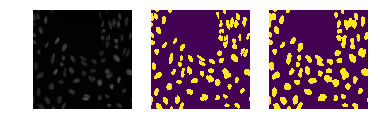

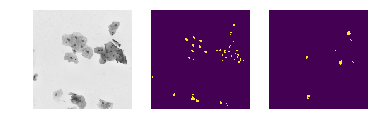

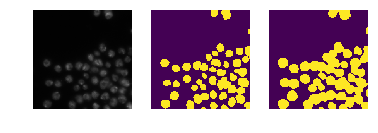

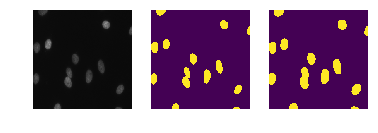

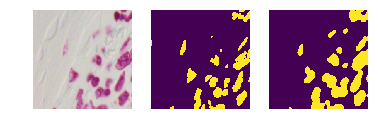

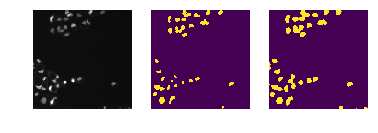

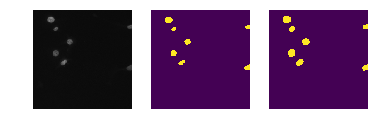

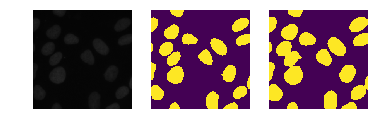

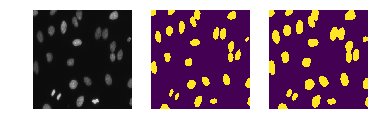

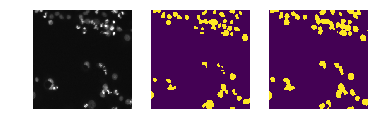

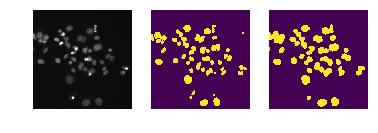

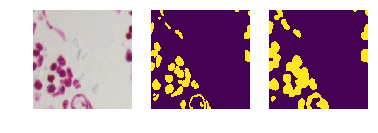

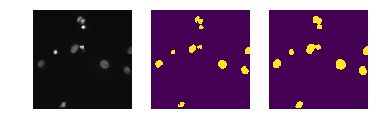

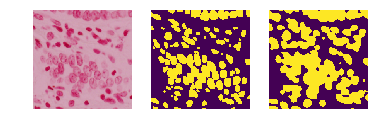

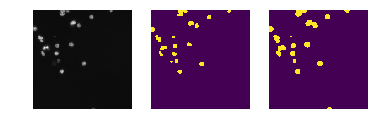

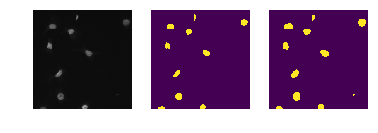

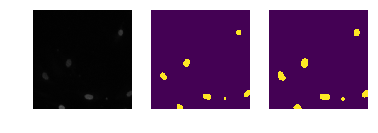

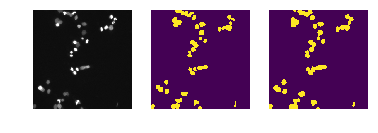

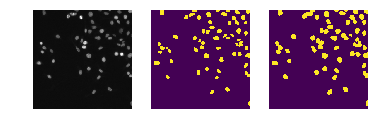

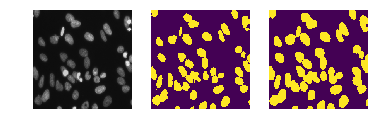

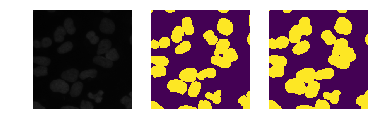

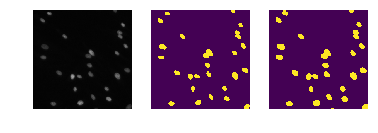

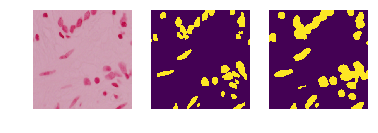

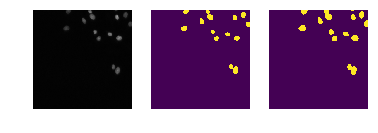

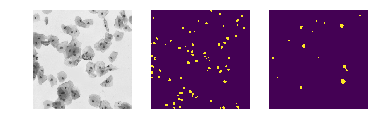

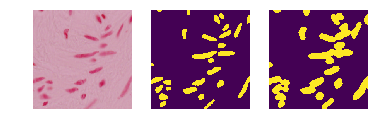

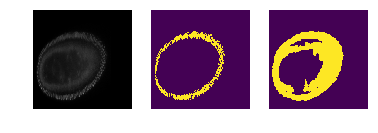

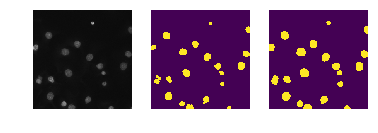

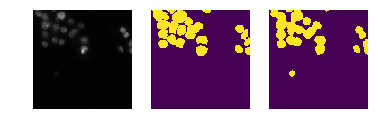

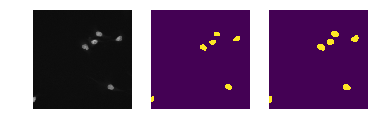

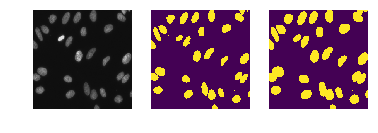

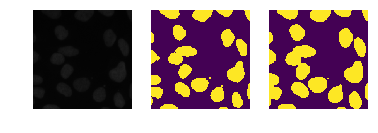

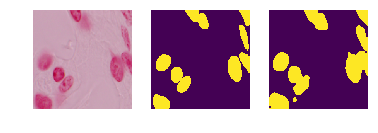

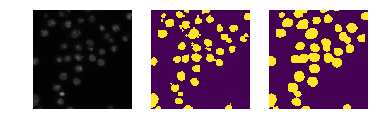

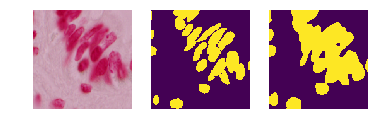

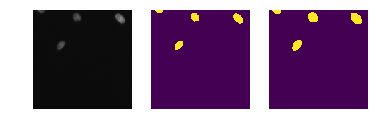

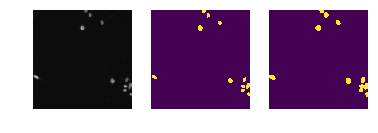

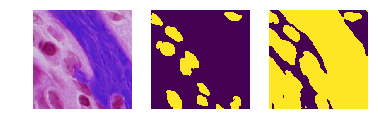

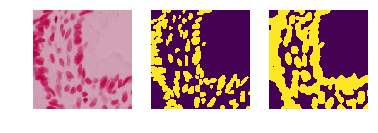

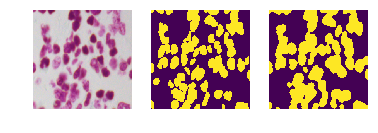

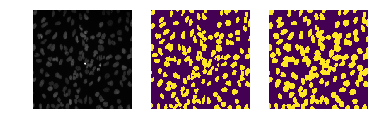

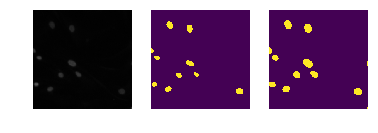

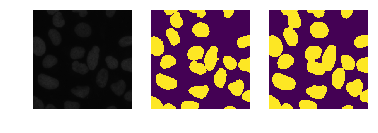

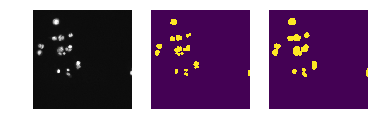

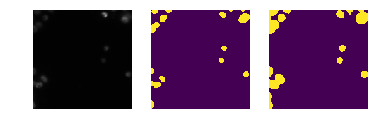

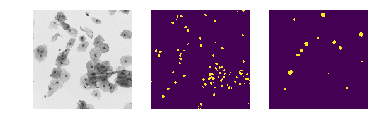

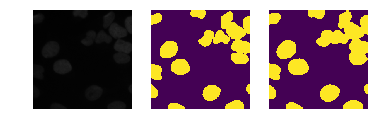

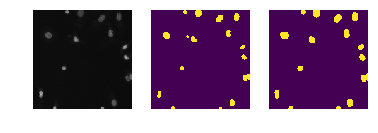

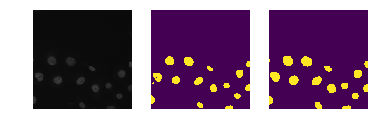

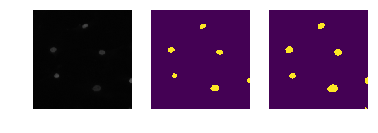

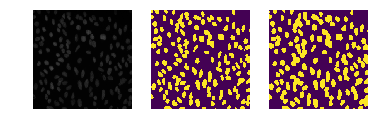

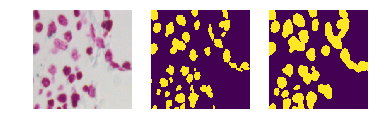

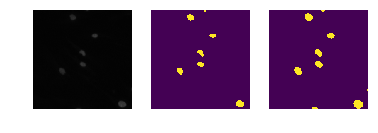

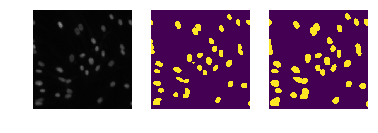

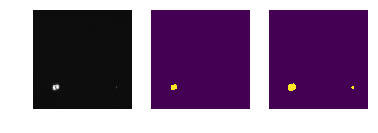

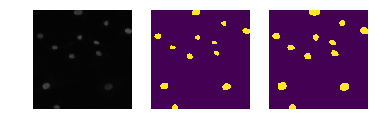

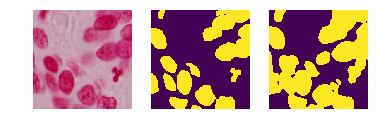

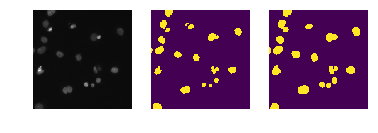

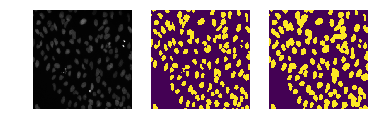

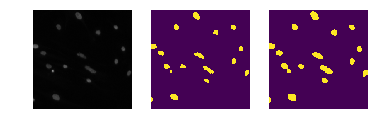

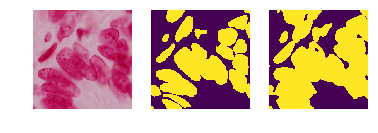

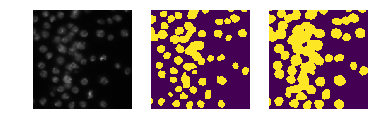

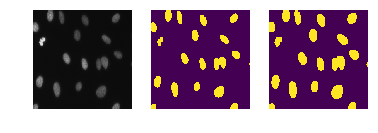

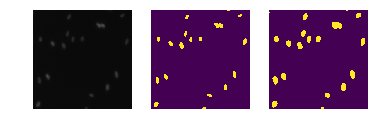

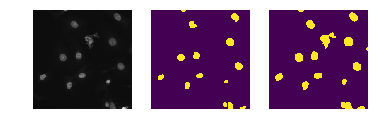

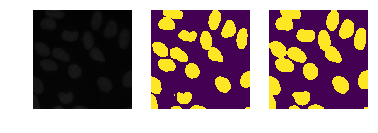

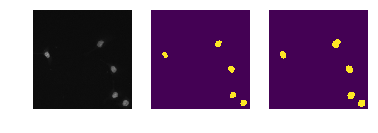

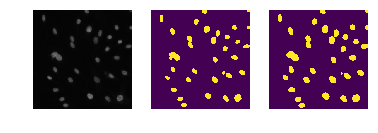

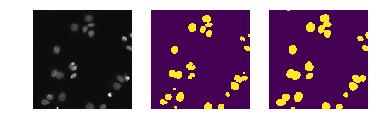

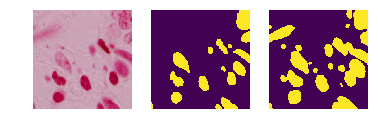

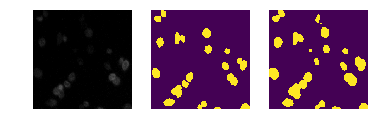

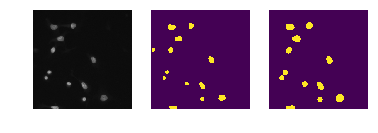

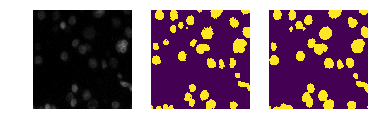

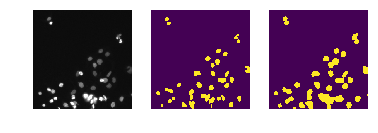

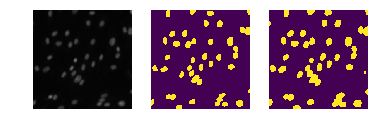

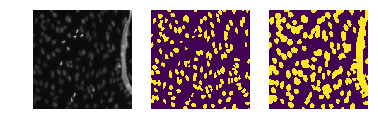

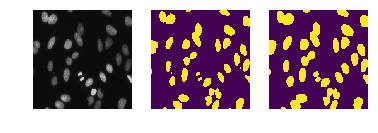

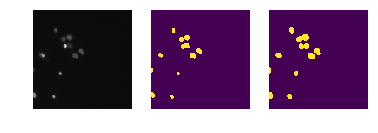

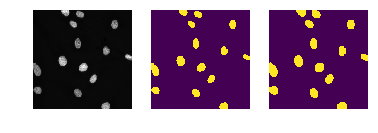

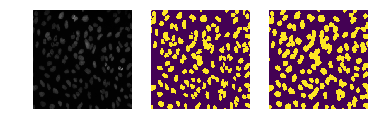

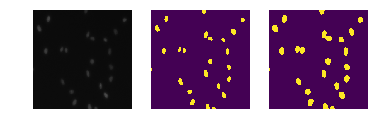

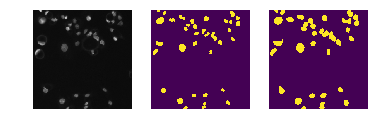

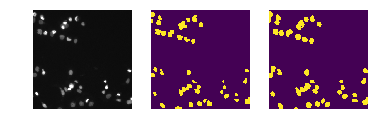

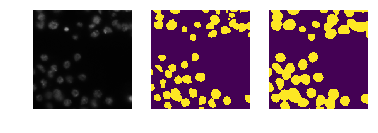

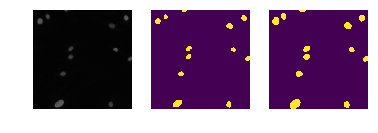

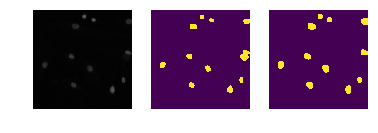

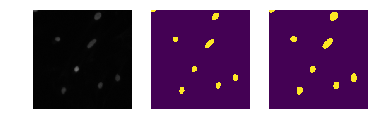

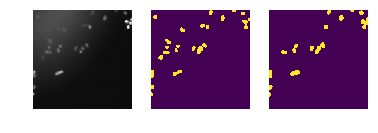

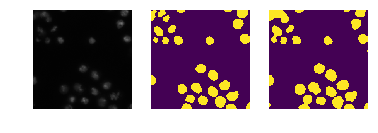

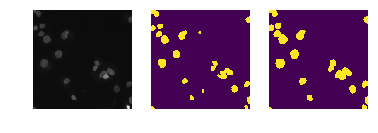

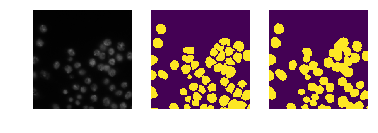

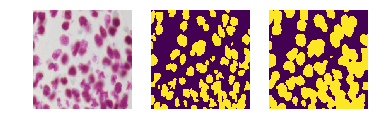

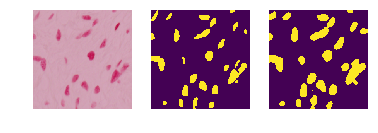

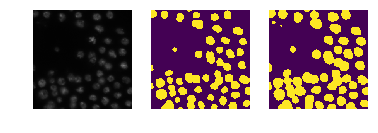

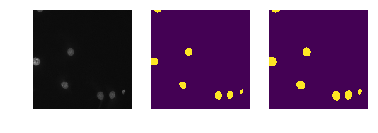

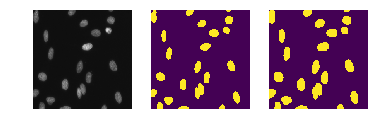

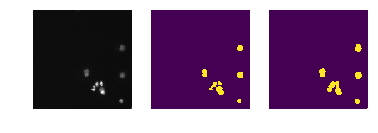

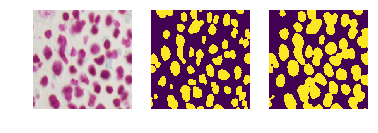

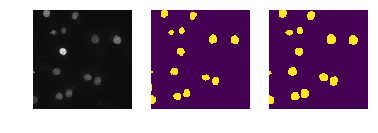

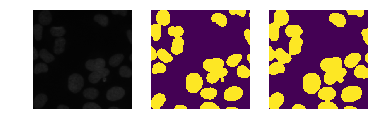

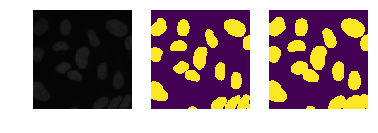

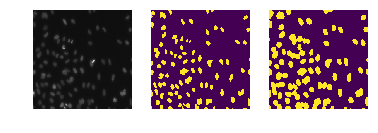

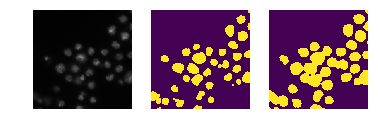

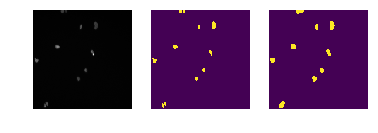

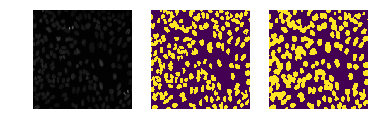

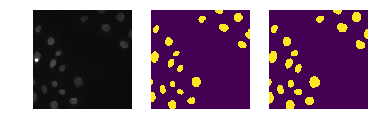

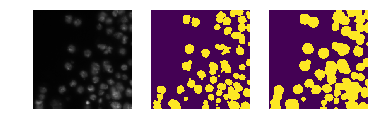

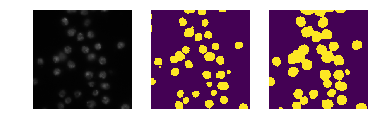

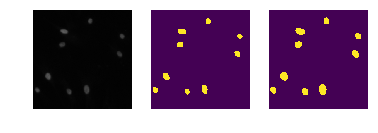

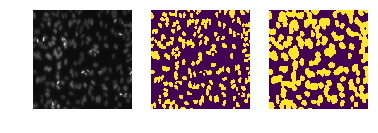

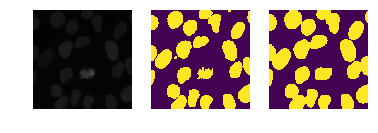

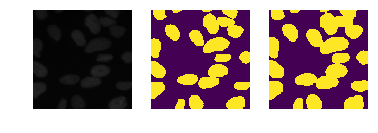

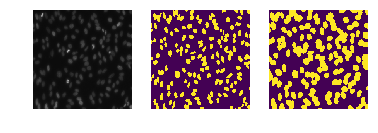

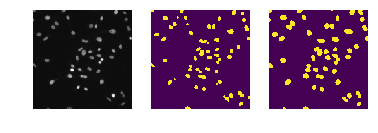

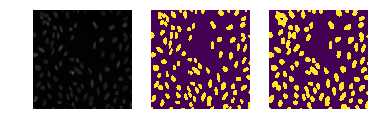

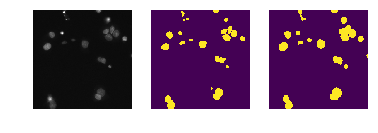

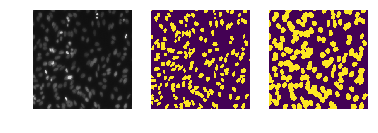

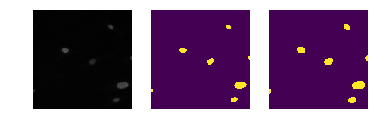

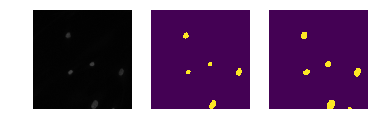

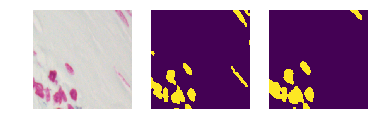

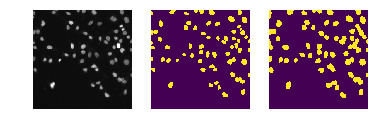

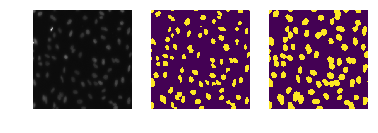

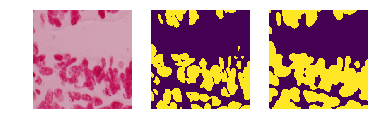

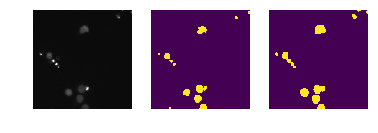

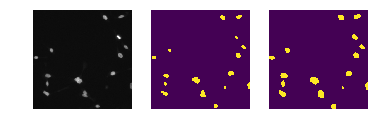

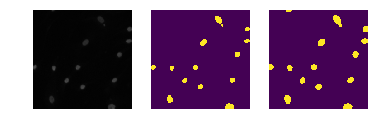

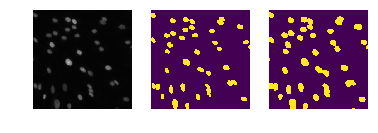

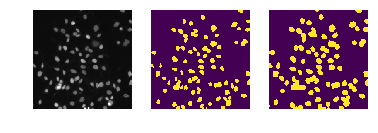

 validation loss:  0.298726


0.29872578212049433

In [26]:
val_jac_loss(net, validation_loader, True)

### Training with printing Jaccard error

 epoch: 10| LR: 0.000200|batch_loss:  0.458646  sum_train_loss: 0.451575
 Jaccard validation error:  0.308898


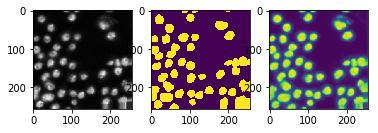

 epoch: 20| LR: 0.000200|batch_loss:  0.371663  sum_train_loss: 0.368933
 Jaccard validation error:  0.372141


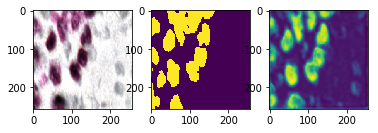

 epoch: 30| LR: 0.000200|batch_loss:  0.292793  sum_train_loss: 0.293648
 Jaccard validation error:  0.268160


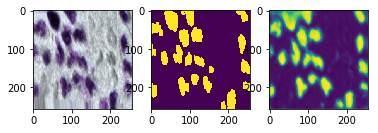

 epoch: 40| LR: 0.000020|batch_loss:  0.278484  sum_train_loss: 0.281344
 Jaccard validation error:  0.278555


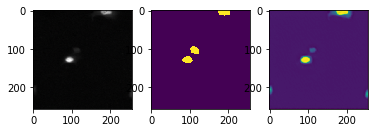

 epoch: 50| LR: 0.000020|batch_loss:  0.261234  sum_train_loss: 0.271454
 Jaccard validation error:  0.263485


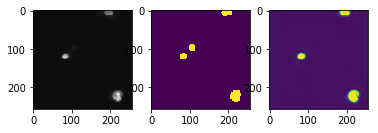

 epoch: 60| LR: 0.000020|batch_loss:  0.278373  sum_train_loss: 0.267427
 Jaccard validation error:  0.274932


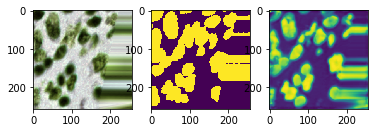

 epoch: 70| LR: 0.000002|batch_loss:  0.255170  sum_train_loss: 0.265099
 Jaccard validation error:  0.266735


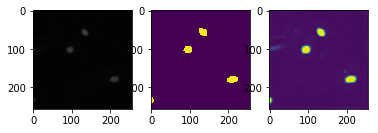

 epoch: 80| LR: 0.000002|batch_loss:  0.256278  sum_train_loss: 0.263732
 Jaccard validation error:  0.264256


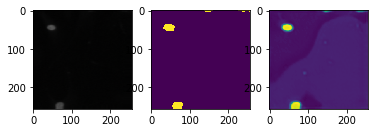

 epoch: 90| LR: 0.000002|batch_loss:  0.261602  sum_train_loss: 0.261756
 Jaccard validation error:  0.266867


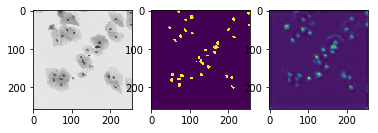

 epoch: 100| LR: 0.000000|batch_loss:  0.252552  sum_train_loss: 0.261788
 Jaccard validation error:  0.268561


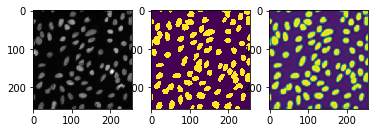

In [19]:
import warnings
warnings.filterwarnings('ignore')
train_BCE, val_BCE = train("BCE", data_aug, True)

In [21]:
print(train_BCE)

[0.45157481729984283, 0.36893296986818314, 0.2936475519090891, 0.28134437650442123, 0.271454144269228, 0.26742670871317387, 0.26509867422282696, 0.26373241655528545, 0.261755870655179, 0.2617883151397109]


In [22]:
print(val_BCE)

[0.3088981662191573, 0.37214143681147127, 0.2681604110651231, 0.2785549905098896, 0.26348520555451144, 0.2749324767687712, 0.2667352176541127, 0.26425641704941233, 0.26686697592293235, 0.26856127821660125]


 epoch: 10| LR: 0.000200|batch_loss:  0.489977  sum_train_loss: 0.511548
 Jaccard validation error:  0.352886


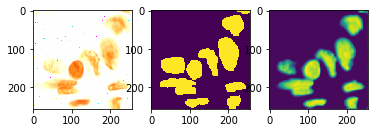

 epoch: 20| LR: 0.000200|batch_loss:  0.370543  sum_train_loss: 0.439328
 Jaccard validation error:  0.351953


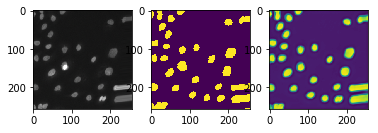

 epoch: 30| LR: 0.000200|batch_loss:  0.351519  sum_train_loss: 0.350778
 Jaccard validation error:  0.367793


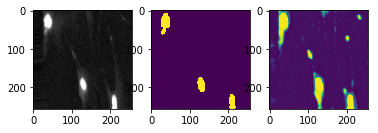

 epoch: 40| LR: 0.000020|batch_loss:  0.428703  sum_train_loss: 0.332073
 Jaccard validation error:  0.310667


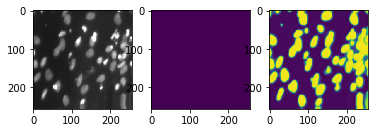

 epoch: 50| LR: 0.000020|batch_loss:  0.314345  sum_train_loss: 0.320820
 Jaccard validation error:  0.317567


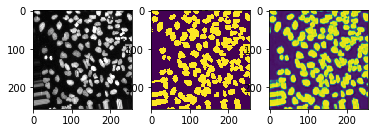

 epoch: 60| LR: 0.000020|batch_loss:  0.321305  sum_train_loss: 0.312566
 Jaccard validation error:  0.312560


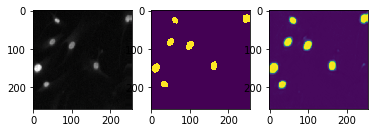

 epoch: 70| LR: 0.000002|batch_loss:  0.275286  sum_train_loss: 0.312959
 Jaccard validation error:  0.310345


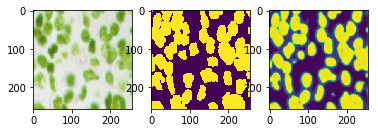

 epoch: 80| LR: 0.000002|batch_loss:  0.281487  sum_train_loss: 0.308691
 Jaccard validation error:  0.307986


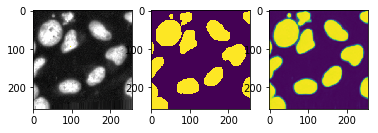

 epoch: 90| LR: 0.000002|batch_loss:  0.309747  sum_train_loss: 0.301879
 Jaccard validation error:  0.305494


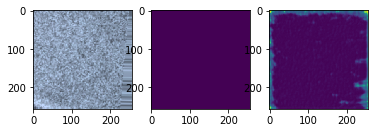

 epoch: 100| LR: 0.000000|batch_loss:  0.283076  sum_train_loss: 0.311664
 Jaccard validation error:  0.307480


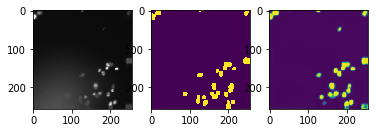

In [19]:
import warnings
warnings.filterwarnings('ignore')
train_DICE, val_DICE = train("DICE", data_aug, True)